In [76]:
import pandas as pd
import math
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import DateFormatter, MinuteLocator, SecondLocator
import matplotlib.ticker as ticker
from scipy.interpolate import spline
from scipy.interpolate import BSpline
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

## Reading in Game of Thrones' subtitles

In [521]:
filenames = glob.glob("Got_s01_s07_subs/*/*.srt")
filenames[:5]

['Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt',
 'Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt',
 'Got_s01_s07_subs/s01/1x03 - Lord Snow.srt',
 'Got_s01_s07_subs/s01/1x04 - Cripples  Bastards  and Broken Things.srt',
 'Got_s01_s07_subs/s01/1x05 - The Wolf and the Lion.srt']

In [522]:
got_episodes = []

for filename in filenames:
    got_episodes.append({
        'content': open(filename).read(),
        'filename': filename,
        'title': re.search(r'(?<=- ).*(?=\.)', filename)[0],
        'season': int(re.search(r'\d(?=x)', filename)[0]),
        'episode': int(re.search(r'(?<=x)\d\d', filename)[0])
    })

got_episodes_df = pd.DataFrame(got_episodes)
got_episodes_df.head(3)

,content,episode,filename,season,title
0,"1\n00:01:55,418 --> 00:01:58,420\nEasy, boy.\n...",1,Got_s01_s07_subs/s01/1x01 - Winter is Coming.srt,1,Winter is Coming
1,"﻿1\n00:00:04,652 --> 00:00:06,681\nThere was a...",2,Got_s01_s07_subs/s01/1x02 - The Kingsroad.srt,1,The Kingsroad
2,"﻿1\n00:00:00,727 --> 00:00:02,930\nStill not f...",3,Got_s01_s07_subs/s01/1x03 - Lord Snow.srt,1,Lord Snow


## Reading in Game of Thrones' episodes length

In [523]:
got_len = pd.read_csv('episodes_length.csv')
got_len.head()

,Season,Episode,Length
0,1,1,61
1,1,2,55
2,1,3,57
3,1,4,55
4,1,5,54


## Extract the dialogues timestamps

In [524]:
dialogues_refined = []

for index, episode in got_episodes_df.iterrows():
    for dialogue in re.compile("\n\n").split(episode['content']):
        if len(re.findall('font color', dialogue)) == 0:
            for time in re.findall('(\d\d:\d\d:\d\d,\d\d\d) --> (\d\d:\d\d:\d\d,\d\d\d)', dialogue):
                dialogues_refined.append({
                    'start': pd.to_datetime(time[0] + '000', format='%H:%M:%S,%f'),
                    'end': pd.to_datetime(time[1] + '000', format='%H:%M:%S,%f'),
                    'episode': episode['episode'],
                    'season': episode['season'],
                    'title': episode['title'],
                })
                
dialogues_refined = pd.DataFrame(dialogues_refined)

In [525]:
dialogues_refined.head()

,end,episode,season,start,title
0,1900-01-01 00:01:58.420,1,1,1900-01-01 00:01:55.418,Winter is Coming
1,1900-01-01 00:02:56.881,1,1,1900-01-01 00:02:55.047,Winter is Coming
2,1900-01-01 00:03:13.331,1,1,1900-01-01 00:03:11.162,Winter is Coming
3,1900-01-01 00:03:15.700,1,1,1900-01-01 00:03:13.365,Winter is Coming
4,1900-01-01 00:03:18.737,1,1,1900-01-01 00:03:15.734,Winter is Coming


## Plot the dialogues

In [526]:
def make_graph(episode_df, limits):
    # Which episode 
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()
    
    # Get the full length of this episode
    episode_length = got_len[
        (got_len['Episode'] == episode_id) 
        & (got_len['Season'] == season_id)]['Length'].item()
    end_hour = '{0:02d}'.format(math.floor(episode_length / 60))
    end_min = '{0:02d}'.format(episode_length % 60)
    
    # Prepare the graph
    plt.subplot(15, 1, episode_id)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().xaxis_date()
    plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    plt.title("Season " + str(season_id) + " Episode " + str(episode_id))
    if limits: plt.gca().set_xlim(limits['start'], limits['end'])
    
    # Plot the dialogues
    for index, line in episode_df.iterrows():
        plt.hlines(0, line.start, line.end, '#a20d7d', alpha=1, lw=10)

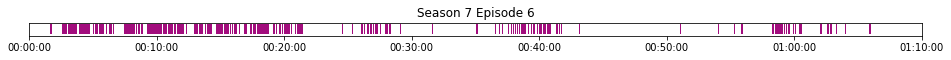

In [527]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=2)
dialogues_refined[
    (dialogues_refined['season'] == 7)
    &(dialogues_refined['episode'] == 6)].groupby('episode').apply(make_graph, {
    'start':pd.Timestamp('1900-01-01 00:00:00.000'),
    'end':pd.Timestamp('1900-01-01 01:10:00.000')})
plt.gca().axes.get_xaxis().set_visible(True)

## Save the graphs to pdf

""


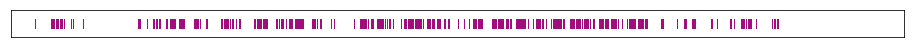

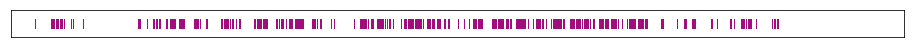

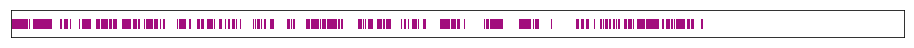

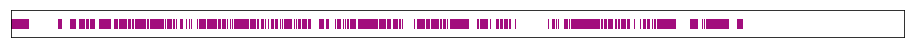

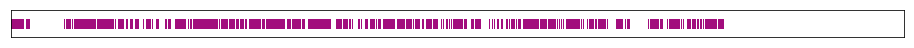

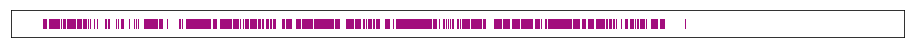

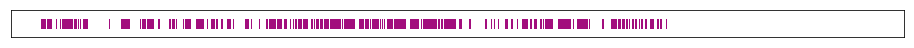

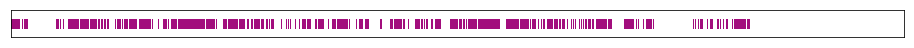

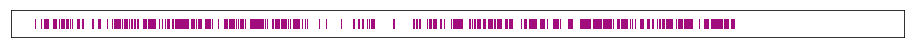

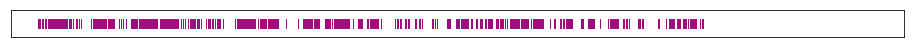

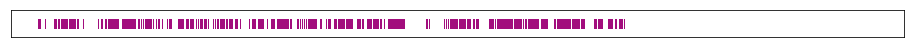

In [528]:
def save_graph(episode_df):
    plt.figure(figsize=(16, .5))
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().set_xlim(
        pd.Timestamp('1900-01-01 00:00:00.000'),
        pd.Timestamp('1900-01-01 01:10:00.000'))

    for index, line in episode_df.iterrows():
        plt.hlines(0, line.start, line.end, '#a20d7d', alpha=1, lw=10)
        
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()
    plt.savefig('output/s' + str(season_id) + 'e' + '{0:02d}'.format(episode_id) + '.png')

    
dialogues_refined[dialogues_refined['season'] == 1].groupby('episode').apply(save_graph)

## Join the dialogues together to have a more readable score

In [529]:
segments = []

for ep_index, ep in dialogues_refined.groupby(['season', 'episode']):
    last_d = pd.DataFrame()
    
    for index, d in ep.iterrows():
        if last_d.empty == False:
            # Seconds allowed to make a junction: 7s
            if d['start'] - last_d['end'] > pd.Timedelta(seconds=7):
                # new segment
                segment_end = last_d['end']    
                segments.append({
                    'start': segment_start,
                    'end': segment_end,
                    'episode': d['episode'],
                    'season': d['season'],
                    'title': d['title']
                })          
                segment_start = d['start']
        else:
            segment_start = d['start']
        last_d = d
    
segments = pd.DataFrame(segments)

## Plot and compare the adjusted version with the original one

In [821]:
# Values used for testing
test_values = {
    'limit_start': pd.Timestamp('1900-01-01 00:00:00.000'),
    'limit_end': pd.Timestamp('1900-01-01 01:10:00.000'),
    'season': 7,
    'episode': 6
}

### Original score

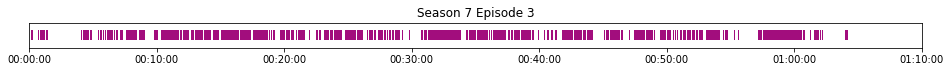

In [813]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    dialogues_refined[
        (dialogues_refined['season'] == test_values['season'])
        &(dialogues_refined['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Joined dialogues score

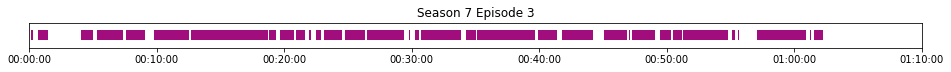

In [814]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Without the isolated short dialogues

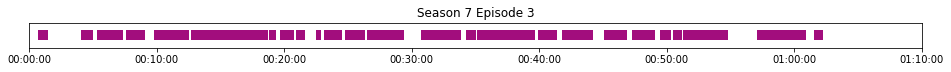

In [815]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=20))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

## Fit the score into a grid of n segments of the same length

In [816]:
def format_timedelta(td):
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return '{:d}:{:02d}:{:02d}'.format(hours, minutes, seconds)

In [817]:
cells_number = 12
limits = {
    'start': pd.Timestamp('1900-01-01 00:00:00.000'),
    'end': pd.Timestamp('1900-01-01 01:10:00.000')
}
cell_length = (limits['end'] - limits['start']) / cells_number
current_cell_time = {}

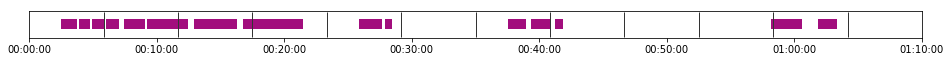

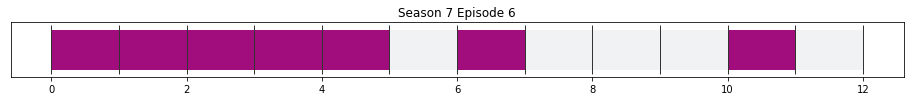

In [822]:
segments_test = segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=30))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])].copy()

plt.figure(figsize=(16, .5))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_xlim(
    pd.Timestamp('1900-01-01 00:00:00.000'),
    pd.Timestamp('1900-01-01 01:10:00.000'))

cells = []
remain = pd.Timedelta(seconds=0)

for ic in range(cells_number):
    
    current_cell_time['start'] = limits['start'] + ic * cell_length
    current_cell_time['end'] = current_cell_time['start'] + cell_length
    cell_fill = pd.Timedelta(seconds=0)
        
    if remain > pd.Timedelta(seconds=0):
        n_covered = math.floor(remain / cell_length)
        
        if n_covered > 0:
            for c in range(n_covered):
                cells.append(True)
                ic = ic + 1
            #remain = remain % n_covered
            next
        
        cell_fill = cell_fill + remain
        remain = pd.Timedelta(seconds=0)
    
    for i, (index, s) in enumerate(segments_test.iterrows()):
        if ic==0:
            plt.hlines(0, s['start'], s['end'], '#a20d7d', alpha=1, lw=10)
        # If the current segment fit the cell
        if (s['start'] > current_cell_time['start']) & (s['end'] < current_cell_time['end']):
            s_length = s['end'] - s['start']
            cell_fill = cell_fill + s_length
        # If the current segment overlap the cell
        else:
            if (s['end'] > current_cell_time['end'])& (s['start'] < current_cell_time['end']):
                remain = s['end'] - current_cell_time['end']
                s['end'] = current_cell_time['end']
                s_length = s['end'] - s['start']
                cell_fill = cell_fill + s_length
    
#     print("Cell -", ic, 
#           "- filled at", format_timedelta(cell_fill), 
#           "remain:", format_timedelta(remain))
    
    cells.append(True if cell_fill > pd.Timedelta(seconds=120) else False)
    plt.vlines(current_cell_time['start']+cell_length, -5, 5, '#333333', alpha=1, lw=1) 

plt.vlines(0, -5, 5, '#333333', alpha=1, lw=1) 
plt.figure(figsize=(16, 1))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x/10)))
plt.title("Season "+ str(test_values['season']) + " Episode "+ str(test_values['episode']))
plt.gca().axes.get_yaxis().set_visible(False)
plt.vlines(0, -20, 20, '#333333', alpha=1, lw=1, zorder=100)
for i, t in enumerate(cells):
    w = 10
    x = i*10 + i*0
    color = '#a20d7d' if t else '#f1f2f3'
    plt.hlines(0, x, x+w, color, alpha=1, lw=40)
    plt.vlines(x+w, -20, 20, '#333333', alpha=1, lw=1, zorder=100)

### Function to be applied to a whole season

In [823]:
def make_cells(episode_df, cells_number, fill_percentage):
    
    # Which episode 
    season_id = episode_df['season'].head(1).item()
    episode_id = episode_df['episode'].head(1).item()

    # Initialize the graph
    limits = {
        'start': pd.Timestamp('1900-01-01 00:00:00.000'),
        'end': pd.Timestamp('1900-01-01 01:10:00.000') }
    cell_length = limits['end'] - limits['start']
    cell_length = cell_length / cells_number
    cells = []
    remain = pd.Timedelta(seconds=0)    
    
    # Draw each cell
    for ic in range(cells_number):
        
        # Initialize the cell
        current_cell_time['start'] = limits['start'] + ic * cell_length
        current_cell_time['end'] = current_cell_time['start'] + cell_length
        cell_fill = pd.Timedelta(seconds=0)
        
        if remain > pd.Timedelta(seconds=0):
            n_covered = math.floor(remain / cell_length)

            if n_covered > 0:
                print(episode_id)
                for c in range(n_covered):
                    cells.append(True)
                    ic = ic + 1
                #remain = remain % n_covered
                next

            cell_fill = cell_fill + remain
            remain = pd.Timedelta(seconds=0)
            
        # Test each segment
        for i, (index, s) in enumerate(episode_df.iterrows()):
                        
            # If the current segment fit the cell
            if (s['start'] > current_cell_time['start']) & (s['end'] < current_cell_time['end']):
                s_length = s['end'] - s['start']
                cell_fill = cell_fill + s_length
            # If the current segment overlap the cell
            else:
                if (s['end'] > current_cell_time['end'])& (s['start'] < current_cell_time['end']):
                    remain = s['end'] - current_cell_time['end']
                    s['end'] = current_cell_time['end']
                    s_length = s['end'] - s['start']
                    cell_fill = cell_fill + s_length

                    
#         print("S"+str(season_id)+"E"+str(episode_id), s['episode'], "Cell -", ic, 
#               "- filled at", format_timedelta(cell_fill),
#               "(" + str(cell_fill/cell_length) + "%)",
#               "remain:", format_timedelta(remain))
                    
        cells.append(True if cell_fill/cell_length > fill_percentage else False)

    plt.subplot(15, 1, episode_id)
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: int(x/10)))
    plt.title("Season "+ str(season_id) + " Episode "+ str(episode_id))
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.vlines(0, -5, 5, '#333333', alpha=1, lw=1) 
    plt.vlines(0, -20, 20, '#333333', alpha=1, lw=1, zorder=100)
    
    for i, t in enumerate(cells):
        w = 10
        x = i*10 + i*0
        color = '#a20d7d' if t else '#f1f2f3'
        plt.hlines(0, x, x+w, color, alpha=1, lw=40)
        plt.vlines(x+w, -20, 20, '#333333', alpha=1, lw=1, zorder=100)

### Plot a season

""


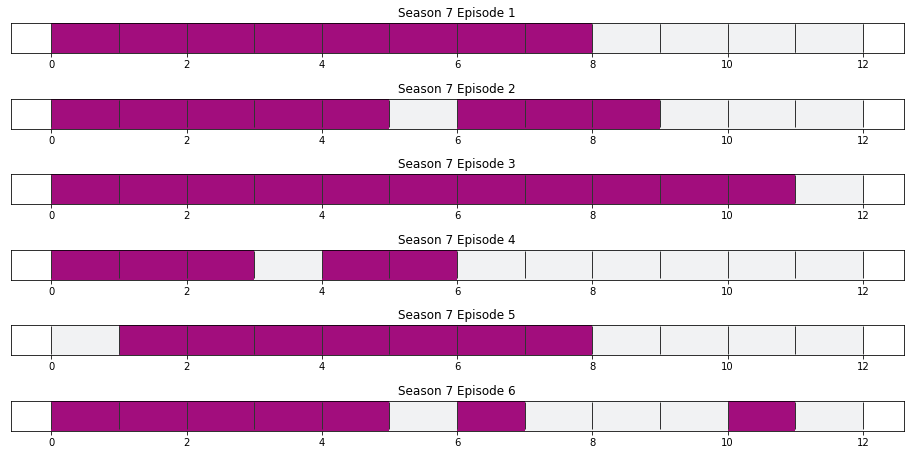

In [820]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=1.5)

(segments[(segments['season'] == 7)&(segments['end'] - segments['start'] > pd.Timedelta(seconds=30))]
 .groupby(['season', 'episode'])
 .apply(make_cells, 12, .343))

## Focus on blank segments

In [539]:
def find_cell_by_time(time):
    return math.floor((time - pd.Timestamp('1900-01-01 00:00:00.000')) / cell_length)

In [540]:
find_cell_by_time(pd.Timestamp('1900-01-01 00:10:20.000'))

2

In [541]:
episodes = (segments[segments['end'] - segments['start'] > pd.Timedelta(seconds=0)]
            .groupby(['season', 'episode']))

blank_segments = []

for ep_index, ep in episodes:
    blank_seg_start = limits['start']
    for i, (index, s) in enumerate(ep.iterrows()):
        #print(s['start'], s['end'], i)
        blank_seg_end = s['start']
        blank_segments.append({
            'start': blank_seg_start,
            'end': blank_seg_end,
            'episode': s['episode'],
            'season': s['season'],
            'title': s['title']
        })
        #print(str(len(blank_segments)-1), blank_seg_start, blank_seg_end)
        blank_seg_start = s['end']
    blank_segments.append({
        'start': s['end'],
        'end': limits['end'],
        'episode': s['episode'],
        'season': s['season'],
        'title': s['title']
    })    
            
blank_segments = pd.DataFrame(blank_segments)

### Empty segments

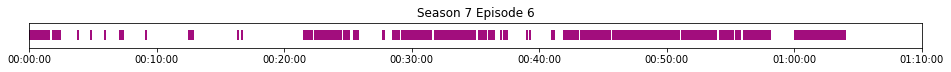

In [542]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    blank_segments[
        (blank_segments['season'] == test_values['season'])
        &(blank_segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Save the empty segments

In [543]:
def time_to_seconds(row):
    start_seconds = (row['start'].second
                     + row['start'].minute*60
                     + row['start'].hour*60*60)
    end_seconds = (row['end'].second
                   + row['end'].minute*60
                   + row['end'].hour*60*60)
    return pd.Series({
        'start_seconds': start_seconds,
        'end_seconds': end_seconds
    })

blank_segments_data = pd.concat([blank_segments.apply(time_to_seconds, axis=1), blank_segments], axis=1)

(blank_segments_data[
    (blank_segments_data['season'] == test_values['season'])
    &(blank_segments_data['episode'] == test_values['episode'])]
 [['start_seconds', 'end_seconds']]
 .to_json('blank_segments.json', orient='values'))

(blank_segments_data[
    (blank_segments_data['season'] == test_values['season'])
    &(blank_segments_data['episode'] == test_values['episode'])]
 [['start_seconds', 'end_seconds']].head())

,start_seconds,end_seconds
2938,0,96
2939,107,147
2940,223,235
2941,284,294
2942,350,359


### Filled segments

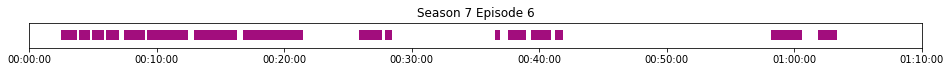

In [544]:
plt.figure(figsize=(16, 10))
plt.subplots_adjust(hspace=.5)
make_graph(
    segments[
        (segments['end'] - segments['start'] > pd.Timedelta(seconds=20))
        &(segments['season'] == test_values['season'])
        &(segments['episode'] == test_values['episode'])],
    {
        'start': test_values['limit_start'],
        'end': test_values['limit_end']
    })
plt.gca().axes.get_xaxis().set_visible(True)

### Add the cells

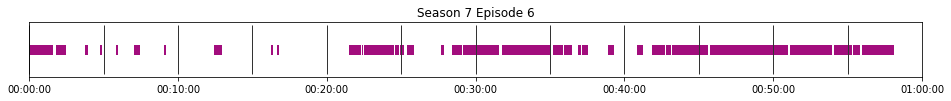

In [545]:
plt.figure(figsize=(16, 1))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
plt.gca().axes.get_yaxis().set_visible(False)
plt.gca().set_xlim(limits['start'], limits['end'])

# Draw the blank segments
for index, s in blank_segments[
        (blank_segments['season'] == test_values['season'])
        &(blank_segments['episode'] == test_values['episode'])].iterrows():
    plt.hlines(0, s['start'], s['end'], '#a20d7d', alpha=1, lw=10)

# Draw the cells
for i in range(cells_number):
    hours, remainder = divmod((cell_length*i).seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    plt.vlines(pd.Timestamp('1900-01-01 '+ str(hours).zfill(3) +':'+ str(minutes).zfill(3) +':00.000'), 
               -20, 20, '#333333', lw=1) 

plt.title("Season "+ str(test_values['season']) + " Episode "+ str(test_values['episode']))
plt.vlines(0, -20, 20, '#333333', lw=1, zorder=100)
plt.gca().axes.get_xaxis().set_visible(True)

## Distribution of the dialogues

### Cut the timeline in slices of n seconds and check if a dialogue occurs in these slices

In [566]:
dist_cell_length = pd.Timedelta(seconds=5)
dist_count = []

# plt.figure(figsize=(16, .5))
# plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
# plt.gca().axes.get_yaxis().set_visible(False)
# plt.gca().set_xlim(
#     pd.Timestamp('1900-01-01 00:00:00.000'),
#     pd.Timestamp('1900-01-01 01:10:00.000'))

for ep_index, ep in dialogues_refined.groupby(['season', 'episode']): 
    t_start = limits['start']
    for t in range((limits['end'] - limits['start']) // dist_cell_length):
        t_end = t_start + dist_cell_length
        #print(t_start, t_end)
        
        for index, d in ep.iterrows():
            if ((d['start'] >= t_start) & (d['start'] < t_end)) | ((d['start'] < t_end) & (d['end'] > t_end)):
                has_dialogue = True
                break
            else:
                has_dialogue = False
  
#         plt.hlines(0, t_start, t_end, '#a20d7d' if has_dialogue else '#f1f2f3', alpha=1, lw=10)
#         plt.title('Every 5 seconds')

                
        t_start = t_start + dist_cell_length
    
        dist_count.append({
            'season': d['season'],
            'episode': d['episode'],
            'minute': t,
            'has_dialogue': has_dialogue
        })
            
    print("Season " + str(d['season']), "episode " + str(d['episode']), "done...")

Season 1 episode 1 done...
Season 1 episode 2 done...
Season 1 episode 3 done...
Season 1 episode 4 done...
Season 1 episode 5 done...
Season 1 episode 6 done...
Season 1 episode 7 done...
Season 1 episode 8 done...
Season 1 episode 9 done...
Season 1 episode 10 done...
Season 2 episode 1 done...
Season 2 episode 2 done...
Season 2 episode 3 done...
Season 2 episode 4 done...
Season 2 episode 5 done...
Season 2 episode 6 done...
Season 2 episode 7 done...
Season 2 episode 8 done...
Season 2 episode 9 done...
Season 2 episode 10 done...
Season 3 episode 1 done...
Season 3 episode 2 done...
Season 3 episode 3 done...
Season 3 episode 4 done...
Season 3 episode 5 done...
Season 3 episode 6 done...
Season 3 episode 7 done...
Season 3 episode 8 done...
Season 3 episode 9 done...
Season 3 episode 10 done...
Season 4 episode 1 done...
Season 4 episode 2 done...
Season 4 episode 3 done...
Season 4 episode 4 done...
Season 4 episode 5 done...
Season 4 episode 6 done...
Season 4 episode 7 done..

In [568]:
dist_count = pd.DataFrame(dist_count)
dist_count.head()

,episode,has_dialogue,minute,season
0,1,False,0,1
1,1,False,1,1
2,1,False,2,1
3,1,False,3,1
4,1,False,4,1


In [77]:
dist_count.to_csv('dialogues_count.csv', index="False")

In [78]:
dist_count = pd.read_csv('dialogues_count.csv')

In [79]:
dist_count['has_dialogue'].value_counts()

True     28782
False    18738
Name: has_dialogue, dtype: int64

### Evolution of intensity during the whole show

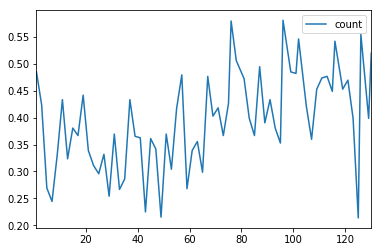

In [80]:
dialogues_pct = (dist_count.groupby(['season', 'episode'])
                   ['has_dialogue'].value_counts(normalize=True)
                   .reset_index(name='count'))
dialogues_pct[dialogues_pct['has_dialogue'] == False].plot(y='count')
plt.savefig('intensity_episodes.pdf')

#### Average values for each season

In [82]:
dialogues_pct[dialogues_pct['has_dialogue'] == False].groupby('season')['count'].mean()

season
1    0.369861
2    0.325278
3    0.334306
4    0.416806
5    0.435417
6    0.465417
7    0.425694
Name: count, dtype: float64

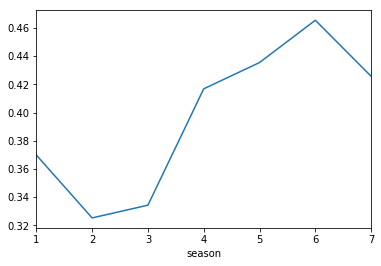

In [81]:
dialogues_pct[dialogues_pct['has_dialogue'] == False].groupby('season')['count'].mean().plot()
plt.savefig('intensity_seasons.pdf')

#### Percentage change

Season 2 -12.0540743522%
Season 3 2.77540563621%
Season 4 24.6780224346%
Season 5 4.46517827391%
Season 6 6.88995215311%
Season 7 -8.53476574157%


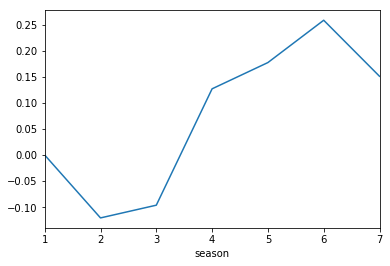

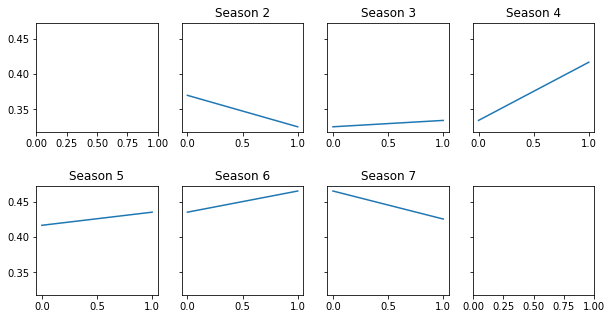

In [75]:
seasons_no_dialogues = dialogues_pct[dialogues_pct['has_dialogue'] == False].groupby('season')
(seasons_no_dialogues
 ['count'].mean()
 .apply(lambda x: x/seasons_no_dialogues.get_group(1)['count'].mean()-1).plot())


f, axarr = plt.subplots(2, 4, sharey=True, figsize=(10,5))
plt.subplots_adjust(hspace=.5)

for index, g in seasons_no_dialogues:
    if index > 1:
        axarr[(index-1)//4, (index-1)%4].plot(
            [0, 1], [seasons_no_dialogues.get_group(index-1)['count'].mean(), g['count'].mean()])
        axarr[(index-1)//4, (index-1)%4].set_title("Season " + str(index))
        print("Season " + str(index), 
              str((g['count'].mean()/seasons_no_dialogues.get_group(index-1)['count'].mean()-1)*100) + "%")
    
plt.savefig('intensity_line_seasons.pdf')

### Evolution of intensity during one season

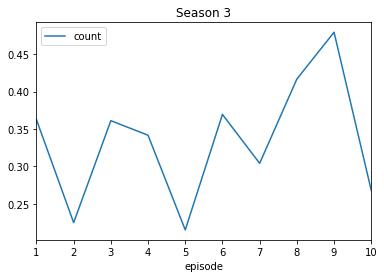

In [854]:
season = 3

dialogues_pct = (dist_count[dist_count['season'] == season].groupby(['season', 'episode'])
                   ['has_dialogue'].value_counts(normalize=True)
                   .reset_index(name='count'))
dialogues_pct[dialogues_pct['has_dialogue'] == False].plot(
    y='count', x='episode', title='Season ' + str(season))

### Histograms

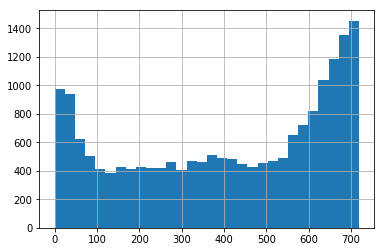

In [576]:
# Histogram of the average episode intensity for the whole show
dist_count[dist_count['has_dialogue'] == False]['minute'].hist(bins=30)

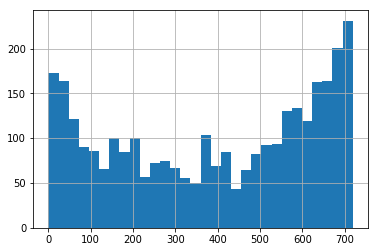

In [861]:
# Histogram of the average episode intensity for one season
dist_count[(dist_count['has_dialogue']== False)&(dist_count['season'] == 5)]['minute'].hist(bins=30)
plt.savefig('intensity_season1.pdf')

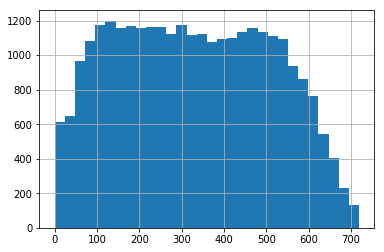

In [577]:
# Histogram of the average episode dialogues the whole show
dist_count[dist_count['has_dialogue'] == True]['minute'].hist(bins=30)

In [573]:
d_data = (dist_count.groupby(dist_count.minute//24)
          ['has_dialogue'].sum()
          .reset_index(name='count'))
d_data['minute'] = d_data['minute']
d_data.head()

,minute,count
0,0,610.0
1,1,647.0
2,2,964.0
3,3,1081.0
4,4,1174.0


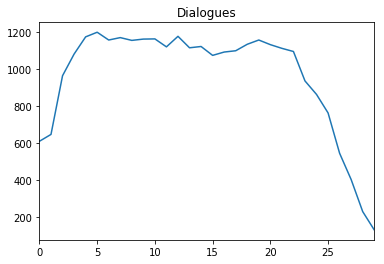

In [574]:
d_data['count'].plot(title='Dialogues')

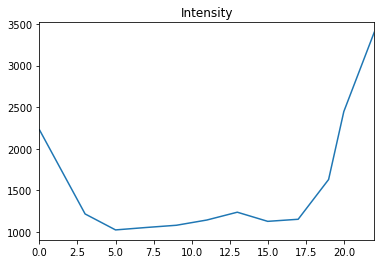

In [575]:
count_dialogues = dist_count.groupby(dist_count.minute//60)['has_dialogue'].value_counts().reset_index(name='count')
count_dialogues[count_dialogues['has_dialogue'] == False]['count'].plot(title='Intensity')